In [1]:
from haar import haar
from pi2 import pi2 
from pi1 import pi1

import numpy as np 

from scipy import integrate
import scipy
from scipy.linalg import lstsq, solve

import matplotlib as mpl
import matplotlib.pyplot as plt 

from numba import njit, prange

mpl.style.use('seaborn')

In [54]:
from scipy.special import airy

def L2_error(approx, exact): 
    return np.sqrt(1 / len(approx) * np.sum((exact-approx)**2)) 

def _integratorle(t, Y): 
    #return np.array([Y[1], -2 / t * Y[1] - Y[0]**5])
   return [Y[1], -2*Y[0]*Y[1]]

def _integratorbvp(t, Y): 
    return np.array([])

def _integratorball(t, Y): 
    return np.array([Y[1], -10 - np.abs(Y[1])*Y[1]])

def integratornl2param(m, n, x): 
    def _integrator(t, Y): 
        return [Y[1], -n * Y[0] * Y[1] + m]
    
    return integrate.solve_ivp(_integrator, t_span=[min(x), max(x)], y0=[0, -1], t_eval=x, method='Radau').y[0, :]

def exactairynl(m, n, x): 
    ai1, aip1, bi1, bip1 = airy(- n / (2* m * n)**(2/3))
    ai2, aip2, bi2, bip2 = airy(n * (m * x - 1) / (2* m * n)**(2/3))

    return 2**(2/3) * m / (m * n) ** (2/3) * ((aip1 * bip2) - bip1*aip2) / (aip1*bi2 - bip1*ai2)

def exact1var(n, x): 
    return - np.sqrt(2 / n) * np.tan(np.sqrt(n / 2) * x)

exacttest = lambda x : - np.tan(x) 
exactbvp = lambda x : np.sin(2*np.sin*x) * (x ** 3 -4 / 3 * x**2 + x / 3)
exactle = lambda x : 1 / np.sqrt(1 + x **2 / 3)
exactball = lambda x : 10 - np.log(np.cosh(np.sqrt(10) * x))

/tmp/ipykernel_524508/542836333.py:27: RuntimeWarning: invalid value encountered in sqrt
  return - np.sqrt(2 / n) * np.tan(np.sqrt(n / 2) * x)


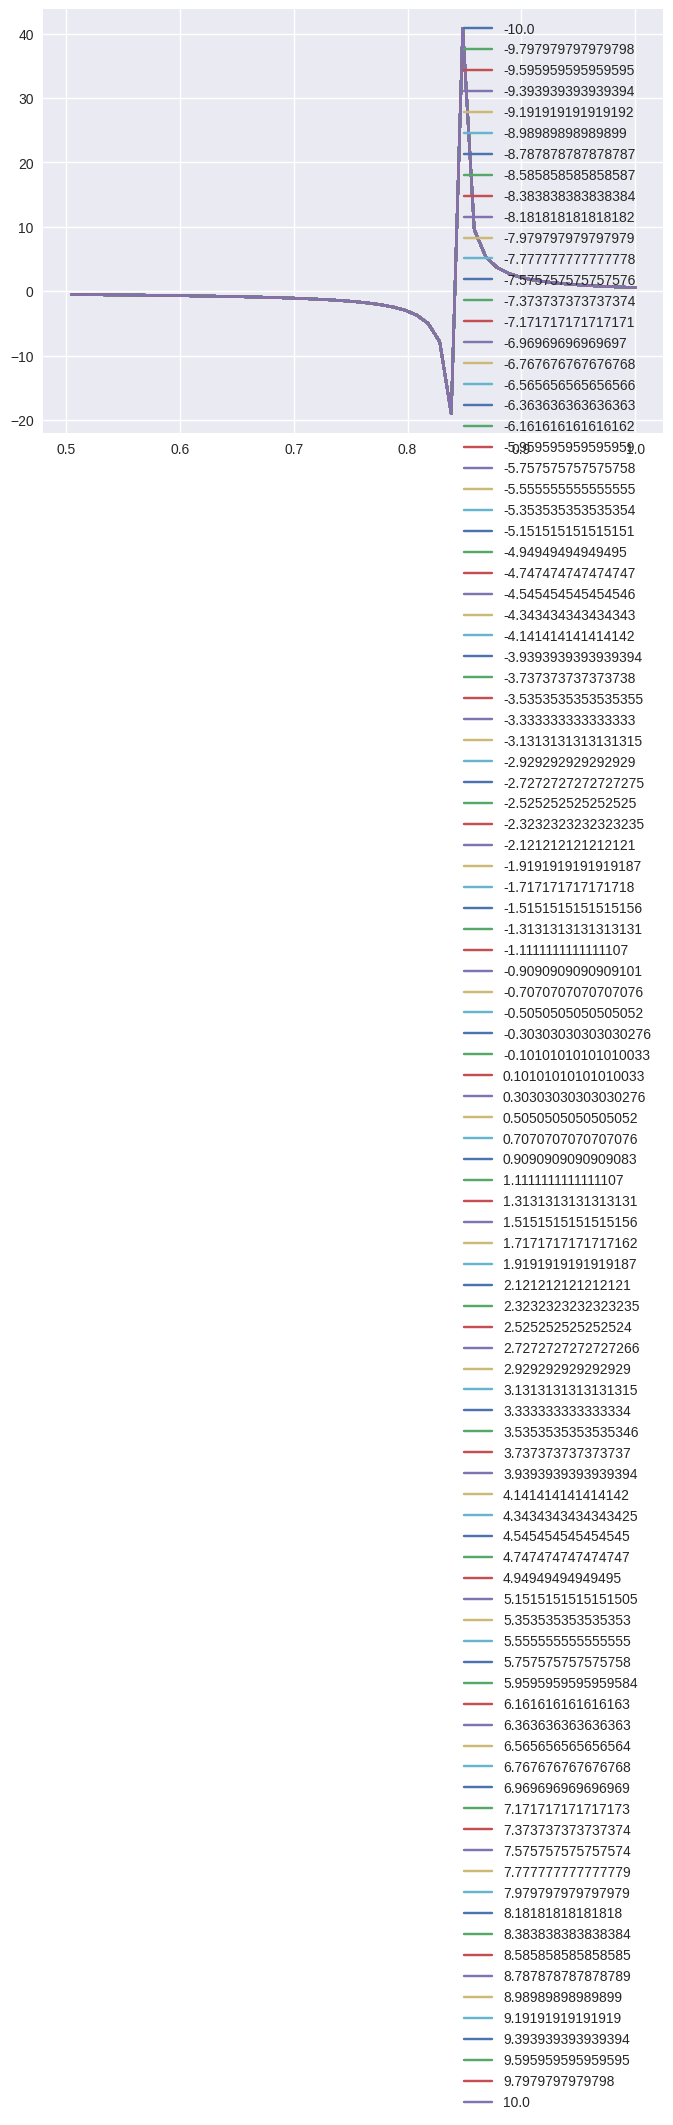

In [87]:
xeval = np.linspace(0, 1, 100) 
n = np.linspace(-10, 10, 100) 

evals = []
for val in n: 
    plt.plot(xeval, exact1var(n, xeval), label=f'{val}')

plt.legend()
    #evals.append(exact1var(n, xeval))

In [94]:
xeval = np.linspace(-9, 9, 100) 

#N, M = np.meshgrid(range(1, 10), range(1, 10))
X, N = np.meshgrid(xeval, range(1, 10)) 

evals = []
for n in range(1,10): 
    for m in range(1, 10): 
        evals.append(exactairynl(m, n, xeval))
        #plt.plot(xeval, exactairynl(m, n, xeval), label=f'{m, n}')

evals = np.array(evals).reshape((100, 9, 9))
#plt.legend()

100


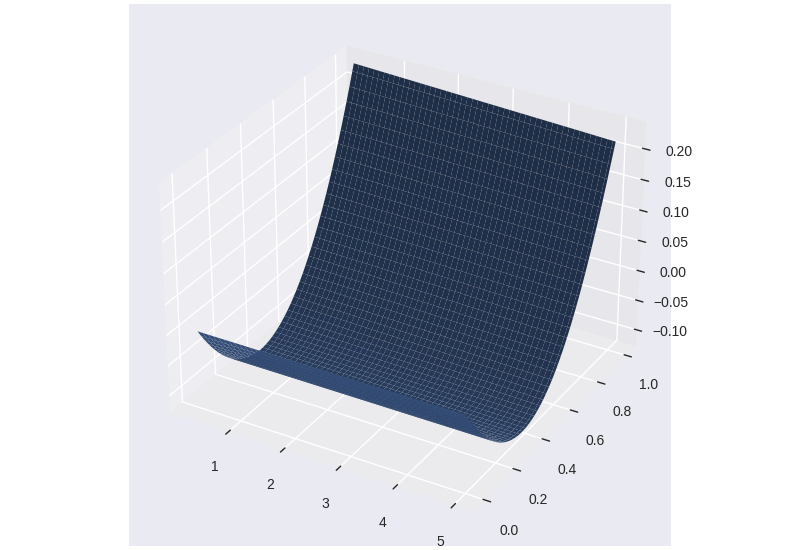

In [71]:
%matplotlib widget 

xeval = np.linspace(0, 1, 100) 
neval = np.linspace(0.25, 5, 100)
#N, M = np.meshgrid(range(1, 10), range(1, 10))
X, N = np.meshgrid(xeval, neval) 

evals = []

for n in neval: 
    evals.append(exactairynl(2.75, n, xeval))

print(len(evals))
evals = np.array(evals).reshape((100, 100))

fig, ax = plt.subplots(subplot_kw = dict(projection="3d"), constrained_layout=1)

ax.plot_surface(N, X, evals)


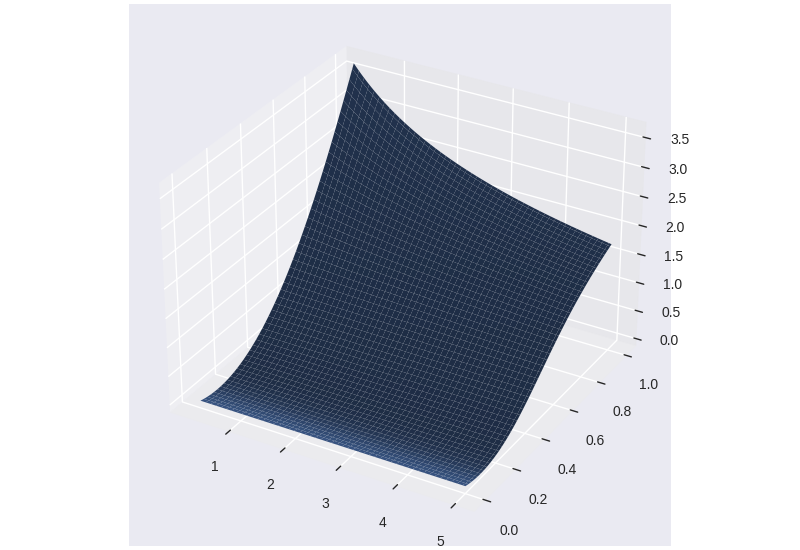

In [77]:
evalsint = []
for n in neval: 
    #print(integratornl2param(0.5, n, xeval).shape)
    evalsint.append(integratornl2param(10, n, xeval))
    
evalsint=np.array(evalsint)
fig, ax = plt.subplots(subplot_kw = dict(projection="3d"), constrained_layout=1)

ax.plot_surface(N, X, evalsint)


In [38]:
fig, ax = plt.subplots(subplot_kw = dict(projection="3d"), constrained_layout=1)

ax.plot_surface(N, X, evals - evalsint)


In [57]:
def wavelet_solve(J, n, m): 
    N = 2**(J + 1) 
    j = np.arange(0, N)
    x = (j - 0.5) / N

    alpha1 = 0.
    beta1 = -1.
    a1 = beta1 - alpha1 

    W = np.zeros((N, N)) 
    f = np.zeros((N, )) 
    a = np.zeros((N, ))

    eps = 1.e-6
    r = np.ones((N, 1))

    iter_idx = 0 

    while max(r) > eps: 
        #for j in range(N): 
        #    H = P1 = P2 = 0 
        H = np.zeros((N, ))
        P1 = np.zeros((N, ))
        P2 = np.zeros((N, ))

        for i in prange(N): 
            H += a[i] * haar(x, i+1, J) 
            P1 += a[i] * pi1(x, i+1, J)             
            P2 += a[i] * pi2(x, i+1, J) 

        #print(H.shape, P1.shape, P2.shape)
        #print(f.shape)
        f = -n * (alpha1 + beta1 * x + P2) * (beta1 + P1) - m + H 
        #print(f.shape)

        for k in prange(N): 
            W[:, k] = -n * pi2(x, k+1, J) * (beta1 + P1) + 2 * (alpha1 + beta1 + x + P2) * pi1(x, k+1, J)  + haar(x, k+1, J) - m

        #print(W.shape, (W@a).shape, f.shape)
        a_new = np.linalg.pinv(W) @ (W@a - f)
        #print(np.linalg.pinv(W).shape, (W@a - f).shape)
        #print(a_new.shape)
        #a_new = lstsq(W, W@a - f, cond=None)[0]
        #a_new = solve(W, W@a - f) # singularities 
        #a_new = scipy.linalg.inv(W) @ (W@a - f)
        #print(a_new.shape)
        r = np.abs(a_new - a) 
        #print(r.shape)
        print(max(r)) 

        a = a_new 
        iter_idx += 1


    y = np.zeros((N, ))
    S = np.zeros((N, ))

    for i in range(N): 
        S += a[i] * pi2(x, i+1, J)

    y = alpha1 + x * beta1 + S 

    return y, x


In [62]:
stest, stestx = wavelet_solve(8, -2, 0)

fig, ax = plt.figure()
ax.plot(stestx, stest)


1.0000187961780593
0.5906890532867557
0.24097052104378158
0.09193174855909159
0.027462575642993037
0.007138758635996934


KeyboardInterrupt: 

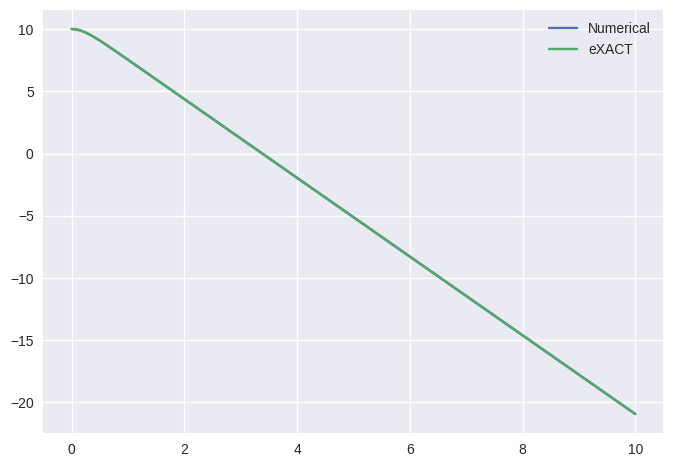

In [67]:
xeval = np.linspace(0.001, 10, 512)

integrator_soln = integrate.solve_ivp(_integratorball, t_span=[0.0, 10],  y0=[10, 0.], method='LSODA') # , t_eval=x, method=method



plt.plot(integrator_soln.t, integrator_soln.y[0,:], label="Numerical")
plt.plot(integrator_soln.t, exactball(integrator_soln.t), label="eXACT")
plt.legend()

In [68]:
L2_error(exactball(integrator_soln.t), integrator_soln.y[0,:]), integrator_soln.t.shape

(0.00024350441190379896, (34,))

In [ ]:
def wavelet_solve(J): 
    N = 2**(J + 1) 
    j = np.arange(0, N)
    x = (j - 0.5) / N

    alpha1 = 10.
    beta1 = 0.
    a1 = beta1 - alpha1 

    W = np.zeros((N, N)) 
    f = np.zeros((N, )) 
    a = np.zeros((N, ))

    eps = 1.e-6
    r = np.ones((N, 1))

    iter_idx = 0 

    while max(r) > eps: 
        #for j in range(N): 
        #    H = P1 = P2 = 0 
        H = np.zeros((N, ))
        P1 = np.zeros((N, ))
        P2 = np.zeros((N, ))

        for i in prange(N): 
            H += a[i] * haar(x, i+1, J) 
            P1 += a[i] * pi1(x, i+1, J)             
            P2 += a[i] * pi2(x, i+1, J) 

        #print(H.shape, P1.shape, P2.shape)
        #print(f.shape)
        #f = 2 * (alpha1 + beta1 * x + P2) * (beta1 + P1) + H 
        #print(f.shape)
        f = 

        for k in prange(N): 
            W[:, k] = 2 * pi2(x, k+1, J) * (beta1 + P1) + 2 * (alpha1 + beta1 + x + P2) * pi1(x, k+1, J)  + haar(x, k+1, J) 

        #print(W.shape, (W@a).shape, f.shape)
        a_new = np.linalg.pinv(W) @ (W@a - f)
        #print(np.linalg.pinv(W).shape, (W@a - f).shape)
        #print(a_new.shape)
        #a_new = lstsq(W, W@a - f, cond=None)[0]
        #a_new = solve(W, W@a - f) # singularities 
        #a_new = scipy.linalg.inv(W) @ (W@a - f)
        #print(a_new.shape)
        r = np.abs(a_new - a) 
        #print(r.shape)
        print(max(r)) 

        a = a_new 
        iter_idx += 1


    y = np.zeros((N, ))
    S = np.zeros((N, ))

    for i in range(N): 
        S += a[i] * pi2(x, i+1, J)

    y = alpha1 + x * beta1 + S 

    return y, x


In [54]:
def _integrator(t, Y): # a = 2, n =  2
    return [Y[1], -1/np.cos(2*t)**2 * (2*np.sin(4*t)*Y[1] + 8 * (np.sin(2*t)**2 + np.cos(2*t)**2)*Y[0])]


In [56]:
integrator_soln = integrate.solve_ivp(_integrator, t_span=[0.0, 1], y0=[0, 1.], method='LSODA') # , t_eval=x, method=method


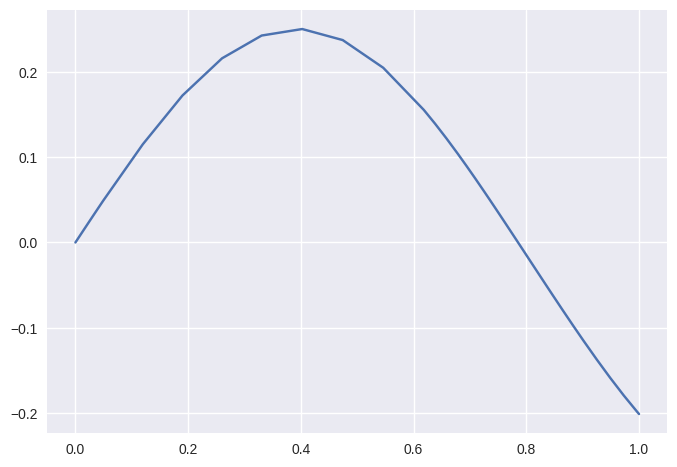

In [57]:
plt.plot(integrator_soln.t, integrator_soln.y[0,:])

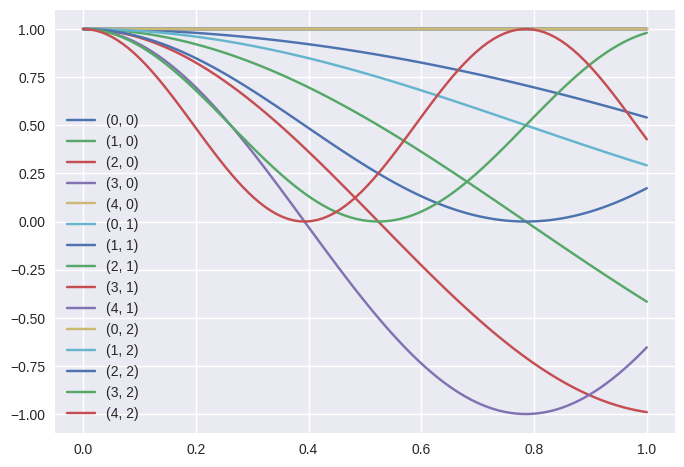

In [53]:
doomcos = lambda x, a, n : np.cos(a * x) ** n

x = np.linspace(0, 1, 100)
for n in range(3): 
    for a in range(5): 
        plt.plot(x, doomcos(x, a, n), label=f"{a, n}")

plt.legend()